In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils

In [32]:
image = './image08.jpg'

In [33]:
image = cv2.imread(image)
ratio = image.shape[0] / 300.0
image = imutils.resize(image, height = 300)

In [34]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(src=gray, ksize=(3,3), sigmaX=0)
T,thresh_image_blured = cv2.threshold(src=blur,thresh=0, maxval=255, type=cv2.THRESH_OTSU)
edged = cv2.Canny(thresh_image_blured, 30, 200)

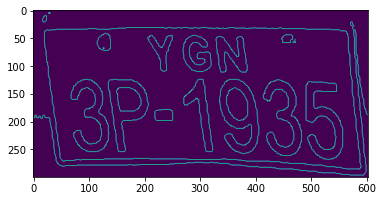

In [35]:
plt.imshow(edged)

In [36]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None

In [27]:
#loop over contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.015 * peri, True)
	# if our approximated contour has four points, then
	# we can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break

In [28]:
# now that we have our screen contour, we need to determine
# the top-left, top-right, bottom-right, and bottom-left
# points so that we can later warp the image -- we'll start
# by reshaping our contour to be our finals and initializing
# our output rectangle in top-left, top-right, bottom-right,
# and bottom-left order
pts = screenCnt.reshape(4, 2)
rect = np.zeros((4, 2), dtype = "float32")
# the top-left point has the smallest sum whereas the
# bottom-right has the largest sum
s = pts.sum(axis = 1)
rect[0] = pts[np.argmin(s)]
rect[2] = pts[np.argmax(s)]
# compute the difference between the points -- the top-right
# will have the minumum difference and the bottom-left will
# have the maximum difference
diff = np.diff(pts, axis = 1)
rect[1] = pts[np.argmin(diff)]
rect[3] = pts[np.argmax(diff)]
# multiply the rectangle by the original ratio
rect *= ratio

In [29]:
# now that we have our rectangle of points, let's compute
# the width of our new image
(tl, tr, br, bl) = rect
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
# ...and now for the height of our new image
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
# take the maximum of the width and height values to reach
# our final dimensions
maxWidth = max(int(widthA), int(widthB))
maxHeight = max(int(heightA), int(heightB))
# construct our destination points which will be used to
# map the screen to a top-down, "birds eye" view
dst = np.array([
	[0, 0],
	[maxWidth - 1, 0],
	[maxWidth - 1, maxHeight - 1],
	[0, maxHeight - 1]], dtype = "float32")
# calculate the perspective transform matrix and warp
# the perspective to grab the screen
M = cv2.getPerspectiveTransform(rect, dst)
warp = cv2.warpPerspective(orig, M, (maxWidth, maxHeight))

In [30]:
# convert the warped image to grayscale and then adjust
# the intensity of the pixels to have minimum and maximum
# values of 0 and 255, respectively
warp = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)
# the pokemon we want to identify will be in the top-right
# corner of the warped image -- let's crop this region out
(h, w) = warp.shape
(dX, dY) = (int(w * 0.4), int(h * 0.45))
crop = warp[10:dY, w - dX:w - 10]
# save the cropped image to file
cv2.imwrite("warped.png", warp)
# show our images
cv2.imshow("image", image)
cv2.imshow("warp", imutils.resize(warp, height = 300))
cv2.waitKey(0)

-1